# Graph Training Sandbox

In [2]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.data import DataLoader

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from utils.toy_utils import *
%matplotlib widget

## Generate hits

Generate circles

In [3]:
# Circle parameters
num_layers = 10
height, width = 10, 10
min_curve, max_curve = 15, 50
noise = False
event_size_min, event_size_max = 4, 12 #I.E. The number of true particle tracks
max_angle=(4/6)*np.pi

## Assign Edges, PIDs, Layer Number & Shuffle

### PIDs and Layer Numbers

### Make Edges

Choose maximum angle

In [3]:
event = gen_graph_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle)

tensor([4])
0.22214007377624512


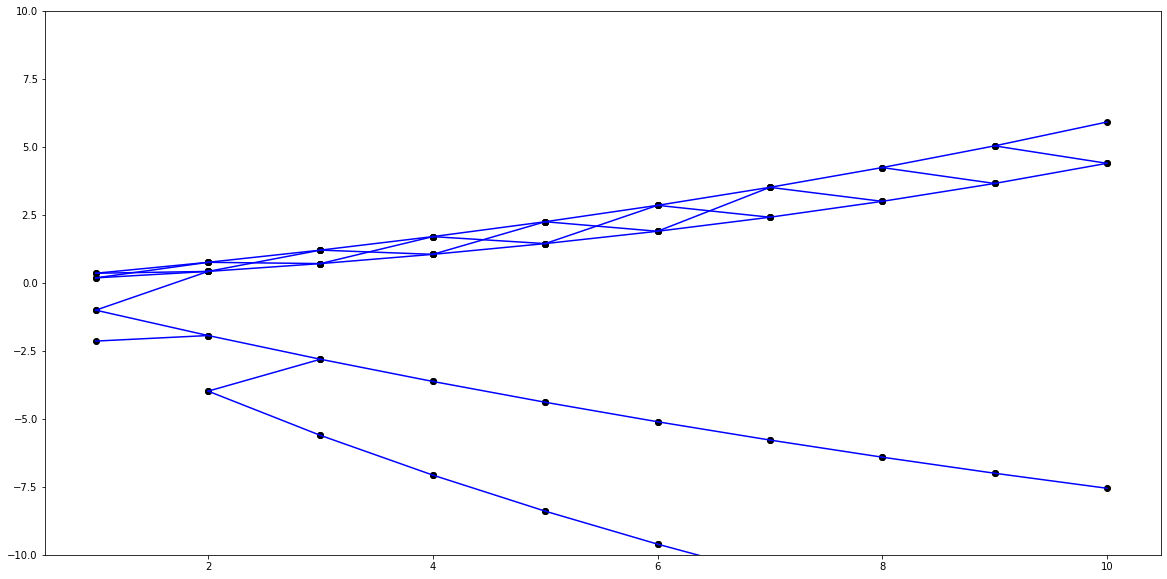

In [4]:
tic = tt()
plt.figure(figsize=(20,10))
X = event.x
e = event.edge_index
y = event.y
print(y)
for i, j in zip(X[e[0]], X[e[1]]):
    plt.plot([i[0], j[0]], [i[1], j[1]], c='b')
#     print(i[0], i[2], j[0], j[2])
    plt.scatter(i[0], i[1], c='k')
    plt.scatter(j[0], j[1], c='k')
plt.ylim(-10,10)
print(tt() - tic)

## Interactive Version of Above

(For fun...)

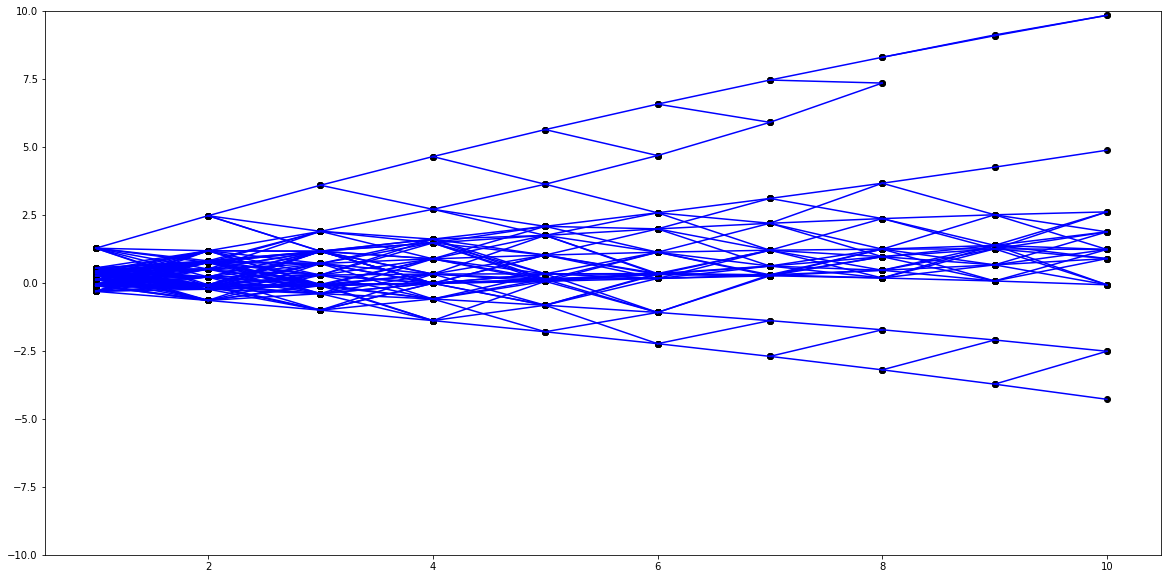

In [3]:
@interact
def gen_plot_event(maximum_of_curve = max_curve, maximum_angle_cutoff = (np.pi/4,np.pi)): 
    event = gen_graph_class(event_size_min, event_size_max, maximum_of_curve, min_curve, height, num_layers, maximum_angle_cutoff)
    plt.figure(figsize=(20,10))
    X = event.x
    e = event.edge_index
    y = event.y
    for i, j in zip(X[e[0]], X[e[1]]):
        plt.plot([i[0], j[0]], [i[1], j[1]], c='b')
    #     print(i[0], i[2], j[0], j[2])
        plt.scatter(i[0], i[1], c='k')
        plt.scatter(j[0], j[1], c='k')
    plt.ylim(-10,10)

## Constructing PyG Datastructure

In [5]:
train_dataset = [gen_graph_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle) for i in range(1000)]
test_dataset = [gen_graph_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle) for i in range(500)]

In [6]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using ", device)
# model = Edge_Class_Net( input_dim=2, hidden_dim=64, n_graph_iters=4).to(device)
model = Net(train_dataset).to(device)
# data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-3)

Using  cuda


## Edge Classification Testing

In [51]:
model.train()
loss_v = []
acc_v = []
ep = 0
for epoch in range(500):
    ep += 1
    correct = 0
    total = 0
    for batch in train_loader:
#         print(batch.x)
        optimizer.zero_grad()
        data = batch.to(device)
        pred = model(data)
        loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float())
        loss.backward()
        optimizer.step()
        correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
#         print(correct, pred, data.y)
        total += len(pred)
#         print(out, data.y, )
    acc = correct/total
    print("Epoch: " , ep, ", loss: ", loss.item(), ", accuracy: ", acc)
    loss_v.append(loss)
    acc_v.append(acc)
plt.plot(np.arange(len(loss_v)), loss_v)
plt.plot(np.arange(len(acc_v)), acc_v)
plt.ylim(0.1,1)

Epoch:  1 , loss:  0.5512356758117676 , accuracy:  0.6864395625058761
Epoch:  2 , loss:  0.5046652555465698 , accuracy:  0.7436710645899276
Epoch:  3 , loss:  0.48637688159942627 , accuracy:  0.7629634272462315
Epoch:  4 , loss:  0.47630026936531067 , accuracy:  0.7705349587890564
Epoch:  5 , loss:  0.4798726439476013 , accuracy:  0.7736814064997336
Epoch:  6 , loss:  0.4695682227611542 , accuracy:  0.7731611770973706
Epoch:  7 , loss:  0.4612908959388733 , accuracy:  0.7738506377511047
Epoch:  8 , loss:  0.44322115182876587 , accuracy:  0.7768779968034097
Epoch:  9 , loss:  0.46184107661247253 , accuracy:  0.7758438058228087
Epoch:  10 , loss:  0.43595728278160095 , accuracy:  0.7730358206148735
Epoch:  11 , loss:  0.40324726700782776 , accuracy:  0.7812466702184336
Epoch:  12 , loss:  0.3373474180698395 , accuracy:  0.7961014133943402
Epoch:  13 , loss:  0.27982667088508606 , accuracy:  0.8321476699363816
Epoch:  14 , loss:  0.2253979742527008 , accuracy:  0.8571813594910527
Epoch:  

KeyboardInterrupt: 

In [52]:
model.eval()
for batch in test_loader:
    print(batch)
    data = batch.to(device)
    pred = model(data)
    correct = ((pred > 0.5) == (data.y > 0.5)).sum().item()
    acc = correct / len(pred)
    print('Accuracy: {:.4f}'.format(acc))

Batch(batch=[5930], edge_index=[2, 14580], x=[5930, 2], y=[14580])
Accuracy: 0.9812
Batch(batch=[5880], edge_index=[2, 14637], x=[5880, 2], y=[14637])
Accuracy: 0.9832
Batch(batch=[5580], edge_index=[2, 14190], x=[5580, 2], y=[14190])
Accuracy: 0.9862
Batch(batch=[5710], edge_index=[2, 14652], x=[5710, 2], y=[14652])
Accuracy: 0.9838
Batch(batch=[5470], edge_index=[2, 12952], x=[5470, 2], y=[12952])
Accuracy: 0.9866


## Track Count Testing


In [9]:
train_dataset = [gen_graph_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle) for i in range(1000)]
test_dataset = [gen_graph_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle) for i in range(500)]

In [10]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using ", device)
# model = Edge_Class_Net( input_dim=2, hidden_dim=64, n_graph_iters=4).to(device)
model = Net(train_dataset).to(device)
# data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

Using  cuda


In [12]:
model.train()
loss_v = []
acc_v = []
ep = 0
for epoch in range(500):
    ep += 1
    correct = 0
    total = 0
    for batch in train_loader:
#         print(batch.x)
        optimizer.zero_grad()
        data = batch.to(device)
        out = model(data)
        _, pred = out.max(dim=1)
        print(pred.shape, data.y.shape, pred, data.y)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        
        correct += float(pred.eq(data.y).sum().item())
#         print(correct, pred, data.y)
        total += len(pred)
#         print(out, data.y, )
    acc = correct/total
    print("Epoch: " , ep, ", loss: ", loss.item(), ", accuracy: ", acc)
    loss_v.append(loss)
    acc_v.append(acc)
plt.plot(np.arange(len(loss_v)), loss_v)
plt.plot(np.arange(len(acc_v)), acc_v)
plt.ylim(0.1,1)

torch.Size([100]) torch.Size([100]) tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6], device='cuda:0') tensor([ 9,  9,  7,  4,  7,  3,  5,  7,  6,  7,  4,  7,  2,  6,  5,  6,  7,  9,
         5,  9,  6,  9,  5,  7,  8,  8,  4,  4,  7,  5,  6,  4,  4,  8, 10,  1,
         5,  8,  8,  5,  8,  4,  9,  5,  9,  6,  2,  9,  5,  4,  7,  4,  9,  5,
         9,  5,  5,  4,  9,  6,  5,  7,  6,  4,  7,  4, 11,  4, 11,  5,  7,  4,
         7,  7,  9,  5,  3,  7,  3,  6,  3,  8,  3,  6,  6,  4,  6,  4,  8,  3,
         7,  7,  8,  2,  6,  6,  3,  4,  8,  2], device='cuda:0')
torch.Size([100]) torch.Size([100]) tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6

KeyboardInterrupt: 

In [23]:
model.eval()
for batch in test_loader:
    print(batch)
    data = batch.to(device)
    _, pred = model(data).max(dim=1)
    print(pred, data.y)
    correct = float(pred.eq(data.y).sum().item())
    acc = correct / len(pred)
    print('Accuracy: {:.4f}'.format(acc))

Batch(batch=[6110], edge_index=[2, 16297], x=[6110, 2], y=[100])
tensor([ 7,  7,  7,  4,  6,  4,  6,  9,  7,  9,  8,  2,  5,  6,  5,  6,  7,  7,
         9,  7,  4,  7,  9,  9,  5,  8,  5,  5,  4,  9,  7,  4,  9,  3,  9,  4,
         6,  5,  4,  6,  4,  7,  3,  5,  5,  4,  5,  5, 10,  5,  2,  7,  9,  6,
        10,  4,  3,  9,  4,  9,  4,  8,  6,  9,  9,  5,  1,  9,  7,  9,  5,  4,
         9,  6,  4,  9,  4,  4,  3,  7,  7,  9,  4,  4,  3,  7,  7,  4,  6,  9,
         7,  9, 10,  7,  9,  4, 10,  5,  7,  6], device='cuda:0') tensor([ 7,  7,  8,  4,  6,  4,  5, 11,  8, 10,  8,  3,  5,  6,  4,  6,  7,  6,
         8,  7,  4,  7,  9,  8,  5,  8,  5,  5,  2, 10,  7,  5,  9,  2,  8,  4,
         6,  5,  4,  6,  4,  7,  3,  5,  6,  5,  5,  6, 10,  5,  2,  6,  7,  6,
        11,  4,  3,  9,  3,  9,  4,  8,  6,  8,  6,  6,  2,  8,  7,  8,  5,  4,
         6,  5,  3,  9,  4,  3,  3,  6,  8, 10,  5,  4,  3,  7,  9,  4,  6,  5,
         7,  9,  9,  7, 10,  4, 11,  5,  6,  6], device='cuda:0')
Acc

## Combined Counter & Classifier

In [8]:
train_dataset = [gen_edge_graph_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle) for i in range(1000)]
test_dataset = [gen_edge_graph_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle) for i in range(500)]

In [9]:
train_dataset[0].y_graph.item()

6

In [5]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using ", device)
# model = Edge_Class_Net( input_dim=2, hidden_dim=64, n_graph_iters=4).to(device)
model = Edge_Graph_Class_Net(input_dim=2, hidden_dim=16, n_graph_iters=4, output_dim=12).to(device)
# data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

Using  cuda


In [23]:
model.train()
loss_v = []
acc_v_count = []
acc_v_edge = []
ep = 0
for epoch in range(500):
    ep += 1
    count_correct = 0
    edge_correct = 0
    count_total = 0
    edge_total = 0 
    for batch in train_loader:
#         print(batch.x)
        optimizer.zero_grad()
        data = batch.to(device)
        edge_pred, graph_pred = model(data)
        _, graph_pred_max = graph_pred.max(dim=1)
        losses = [F.binary_cross_entropy_with_logits(edge_pred.float(), data.y.float()), F.cross_entropy(graph_pred, data.y_graph)]
#         print(losses[0].item(), losses[1].item())
        loss = sum(losses)
        loss.backward()
        optimizer.step()

        edge_correct += ((edge_pred > 0.5) == (data.y > 0.5)).sum().item()
        count_correct += float(graph_pred_max.eq(data.y_graph).sum().item())
#         print(correct, pred, data.y)
        count_total += len(graph_pred_max)
        edge_total += len(edge_pred)
#         print(out, data.y, )
    count_acc = count_correct/count_total
    edge_acc = edge_correct / edge_total
    print("Epoch: " , ep, ", loss: ", loss.item(), ", count accuracy: ", count_acc, ", edge accuracy: ", edge_acc)
    loss_v.append(loss)
    acc_v_count.append(count_acc)
    acc_v_edge.append(edge_acc)
plt.plot(np.arange(len(loss_v)), loss_v)
plt.plot(np.arange(len(acc_v_count)), acc_v_count)
plt.plot(np.arange(len(acc_v_edge)), acc_v_edge)
plt.ylim(0.1,1)

Epoch:  1 , loss:  3.1576285362243652 , count accuracy:  0.122 , edge accuracy:  0.6513064133016627
Epoch:  2 , loss:  3.1742045879364014 , count accuracy:  0.134 , edge accuracy:  0.6614945111382166
Epoch:  3 , loss:  3.0324511528015137 , count accuracy:  0.134 , edge accuracy:  0.6614945111382166
Epoch:  4 , loss:  3.011707305908203 , count accuracy:  0.158 , edge accuracy:  0.6614945111382166
Epoch:  5 , loss:  3.0208494663238525 , count accuracy:  0.196 , edge accuracy:  0.6620851255055531
Epoch:  6 , loss:  3.003718137741089 , count accuracy:  0.182 , edge accuracy:  0.6734865506837003
Epoch:  7 , loss:  2.8945674896240234 , count accuracy:  0.193 , edge accuracy:  0.6919881877126532
Epoch:  8 , loss:  2.9283816814422607 , count accuracy:  0.194 , edge accuracy:  0.7084547730628491
Epoch:  9 , loss:  2.8948309421539307 , count accuracy:  0.204 , edge accuracy:  0.7297875072221865
Epoch:  10 , loss:  2.914076328277588 , count accuracy:  0.208 , edge accuracy:  0.746857546382487
Epo

KeyboardInterrupt: 

In [11]:
model.eval()
for batch in test_loader:
    print(batch)
    data = batch.to(device)
    edge_pred, graph_pred = model(data)
    _, graph_pred_max = graph_pred.max(dim=1)
    correct = float(graph_pred_max.eq(data.y_graph).sum().item())
    acc = correct / len(graph_pred_max)
    print('Accuracy: {:.4f}'.format(acc))

Batch(batch=[5910], edge_index=[2, 14768], x=[5910, 2], y=[14768], y_graph=[100])
Accuracy: 0.6900
Batch(batch=[6130], edge_index=[2, 15735], x=[6130, 2], y=[15735], y_graph=[100])
Accuracy: 0.7000
Batch(batch=[6460], edge_index=[2, 17175], x=[6460, 2], y=[17175], y_graph=[100])
Accuracy: 0.6700
Batch(batch=[6180], edge_index=[2, 15944], x=[6180, 2], y=[15944], y_graph=[100])
Accuracy: 0.6800
Batch(batch=[6110], edge_index=[2, 15557], x=[6110, 2], y=[15557], y_graph=[100])
Accuracy: 0.8600


## Combined Edge & Track Param Classifier

In [4]:
# Generate event data from random parameters
def gen_edge_track_params(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle):
    radii, dirs, signs, event_size = rand_pars(event_size_min, event_size_max, max_curve, min_curve)
    xys = []
    X = np.empty([6,1])
    x = np.arange(0 + height/num_layers,height + height/num_layers, height/num_layers)
    i = 0
    for r, d, s in zip(radii, dirs, signs):
        y1test = y1(x, r, d, s)
    #     print(y1test, x)
        y2test = y2(x, r, d, s)
        if -2.5 < y1test[0] < 2.5 and not any(np.isnan(y1test)):
            X = np.append(X, np.vstack((y1test, np.array([i]*len(y1test)), x, np.array([r]*len(y1test))/max_curve, np.array([d]*len(y1test))/max_curve, np.array([s]*len(y1test)) )), axis=1)
            i += 1
        if -2.5 < y2test[0] < 2.5 and not any(np.isnan(y2test)):
            X = np.append(X, np.vstack((y2test, np.array([i]*len(y2test)), x, np.array([r]*len(y2test))/max_curve, np.array([d]*len(y2test))/max_curve, np.array([s]*len(y2test)) )), axis=1)
            i += 1
    X = X[:,1:].T
    np.random.shuffle(X)
    
    e = np.array([[i,j] for layer in np.arange(num_layers) for i in np.argwhere(X[:,2] == layer) for j in np.argwhere(X[:,2] == (layer+1)) if (X[i, 0] - np.tan(max_angle/2) < X[j, 0] < X[i, 0] + np.tan(max_angle/2))]).T[0]
    y_edge = np.array([int(i[1] == j[1]) for i,j in zip(X[e[0]], X[e[1]])])
    
    data = Data(x = torch.from_numpy(np.array([X[:,2], X[:,0]]).T).float(), edge_index = torch.from_numpy(e), y = torch.from_numpy(y_edge), y_nodes = torch.from_numpy(np.array([X[:,3], X[:,4], X[:,5]]).T).float())
    
    return data

In [5]:
class Edge_Track_Net(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, input_dim=3, hidden_dim=8, n_graph_iters=3,
                 output_dim=3, hidden_activation=nn.ReLU, layer_norm=True):
        super(Edge_Track_Net, self).__init__()
        self.n_graph_iters = n_graph_iters
        # Setup the input network
        self.input_network = make_mlp(input_dim, [hidden_dim],
                                      output_activation=nn.Tanh,
                                      layer_norm=layer_norm)
        # Setup the edge network
        self.edge_network = EdgeNetwork(input_dim+hidden_dim, hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        # Setup the node layers
        self.node_network = NodeNetwork(input_dim+hidden_dim, hidden_dim,
                                        hidden_activation, layer_norm=False)
        
        self.output_network = make_mlp(input_dim+hidden_dim, [hidden_dim, output_dim],
                                       hidden_activation=nn.Tanhshrink,
                                      output_activation=nn.Tanhshrink,
                                      layer_norm=False)

    def forward(self, inputs):
        """Apply forward pass of the model"""
        # Apply input network to get hidden representation
        x = self.input_network(inputs.x)
        # Shortcut connect the inputs onto the hidden representation
        x = torch.cat([x, inputs.x], dim=-1)
        # Loop over iterations of edge and node networks
        for i in range(self.n_graph_iters):
            # Apply edge network
            e = torch.sigmoid(self.edge_network(x, inputs.edge_index))
            # Apply node network
            x = self.node_network(x, e, inputs.edge_index)
            # Shortcut connect the inputs onto the hidden representation
            x = torch.cat([x, inputs.x], dim=-1)
        # Apply final edge network
        return self.edge_network(x, inputs.edge_index), self.output_network(x)

In [23]:
track_data = gen_edge_track_params(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle)
track_data

Data(edge_index=[2, 50], x=[40, 2], y=[50], y_nodes=[40, 3])

#### Generate data

In [6]:
train_dataset = [gen_edge_track_params(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle) for i in range(2000)]
test_dataset = [gen_edge_track_params(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle) for i in range(10)]

../utils/toy_utils.py:32: RuntimeWarning: invalid value encountered in sqrt
  return sign*np.sqrt(r**2 - a**2) + np.sqrt(r**2 - (x-a)**2)
../utils/toy_utils.py:34: RuntimeWarning: invalid value encountered in sqrt
  return sign*np.sqrt(r**2 - a**2) - np.sqrt(r**2 - (x-a)**2)


#### Load data

In [ ]:
READ GRAPH FILES

In [7]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using ", device)
# model = Edge_Class_Net( input_dim=2, hidden_dim=64, n_graph_iters=4).to(device)
model = Edge_Track_Net(input_dim=2, hidden_dim=128, n_graph_iters=6, output_dim=3).to(device)
# data = dataset[0].to(device)
learning_rate=0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.95)

Using  cuda


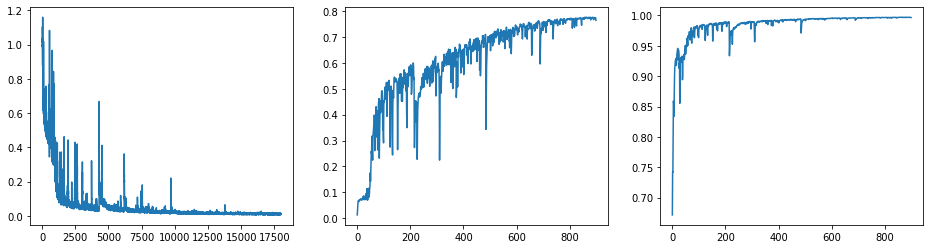

In [139]:
fig, axs = plt.subplots(1,3)
fig.set_size_inches(16,4)
axs[0].plot(np.arange(len(loss_v)-10), loss_v[10:])
axs[1].plot(np.arange(len(acc_v_node)), acc_v_node)
axs[2].plot(np.arange(len(acc_v_edge)), acc_v_edge)

Epoch:  301 , loss:  0.03807494044303894 , node accuracy:  0.6203550683138346 , edge accuracy:  0.9914085738734136  lr:  [0.0021463876394293728]
Epoch:  302 , loss:  0.02422183007001877 , node accuracy:  0.6015544465352205 , edge accuracy:  0.9915214127426427  lr:  [0.0021463876394293728]
Epoch:  303 , loss:  0.02895829826593399 , node accuracy:  0.6316998009217595 , edge accuracy:  0.9923677042618614  lr:  [0.0021463876394293728]
Epoch:  304 , loss:  0.02243342623114586 , node accuracy:  0.6381275736998555 , edge accuracy:  0.9924053172182711  lr:  [0.0021463876394293728]
Epoch:  305 , loss:  0.024189382791519165 , node accuracy:  0.6389402492568654 , edge accuracy:  0.9928441350430511  lr:  [0.0021463876394293728]
Epoch:  306 , loss:  0.019930360838770866 , node accuracy:  0.6476751479451308 , edge accuracy:  0.9928880168255292  lr:  [0.0021463876394293728]
Epoch:  307 , loss:  0.02068352699279785 , node accuracy:  0.6371812702828001 , edge accuracy:  0.9930008556947583  lr:  [0.0021

Epoch:  358 , loss:  0.024374233558773994 , node accuracy:  0.6020371430908942 , edge accuracy:  0.9925024840223295  lr:  [0.0019371148445850087]
Epoch:  359 , loss:  0.03252456337213516 , node accuracy:  0.608669448307835 , edge accuracy:  0.9921765050667787  lr:  [0.0019371148445850087]
Epoch:  360 , loss:  0.025500774383544922 , node accuracy:  0.658747170634596 , edge accuracy:  0.9928535382821536  lr:  [0.0018402591023557583]
Epoch:  361 , loss:  0.02719375491142273 , node accuracy:  0.656701846246148 , edge accuracy:  0.9926686079131392  lr:  [0.0018402591023557583]
Epoch:  362 , loss:  0.02008230797946453 , node accuracy:  0.6347923313970929 , edge accuracy:  0.9924742743050222  lr:  [0.0018402591023557583]
Epoch:  363 , loss:  0.019930299371480942 , node accuracy:  0.648744170825493 , edge accuracy:  0.9933581787806507  lr:  [0.0018402591023557583]
Epoch:  364 , loss:  0.022470667958259583 , node accuracy:  0.6489023425781996 , edge accuracy:  0.9929820492165534  lr:  [0.001840

Epoch:  415 , loss:  0.019477253779768944 , node accuracy:  0.6299326406501404 , edge accuracy:  0.9929789148035193  lr:  [0.0016608338398760717]
Epoch:  416 , loss:  0.023310475051403046 , node accuracy:  0.6559355313752762 , edge accuracy:  0.9936120662364163  lr:  [0.0016608338398760717]
Epoch:  417 , loss:  0.030934715643525124 , node accuracy:  0.6107611333824211 , edge accuracy:  0.9930886192597144  lr:  [0.0016608338398760717]
Epoch:  418 , loss:  0.026511240750551224 , node accuracy:  0.6330415337205815 , edge accuracy:  0.9935054961932553  lr:  [0.0016608338398760717]
Epoch:  419 , loss:  0.018202604725956917 , node accuracy:  0.6401428999972729 , edge accuracy:  0.9931199633900558  lr:  [0.0016608338398760717]
Epoch:  420 , loss:  0.02364617958664894 , node accuracy:  0.6400774496168425 , edge accuracy:  0.9936371415406894  lr:  [0.001577792147882268]
Epoch:  421 , loss:  0.01685064285993576 , node accuracy:  0.6530366249420492 , edge accuracy:  0.9931419042812948  lr:  [0.00

Epoch:  472 , loss:  0.01701701618731022 , node accuracy:  0.6502986173607134 , edge accuracy:  0.9940822281915377  lr:  [0.0014239574134637467]
Epoch:  473 , loss:  0.020422007888555527 , node accuracy:  0.648648722354032 , edge accuracy:  0.9945179116032836  lr:  [0.0014239574134637467]
Epoch:  474 , loss:  0.01937570609152317 , node accuracy:  0.6617851591262375 , edge accuracy:  0.9936841577362016  lr:  [0.0014239574134637467]
Epoch:  475 , loss:  0.01828273944556713 , node accuracy:  0.6753797485614552 , edge accuracy:  0.9945649277987958  lr:  [0.0014239574134637467]
Epoch:  476 , loss:  0.018007123842835426 , node accuracy:  0.690125173852573 , edge accuracy:  0.9946714978419566  lr:  [0.0014239574134637467]
Epoch:  477 , loss:  0.01472439058125019 , node accuracy:  0.660609779377676 , edge accuracy:  0.9941010346697425  lr:  [0.0014239574134637467]
Epoch:  478 , loss:  0.027825597673654556 , node accuracy:  0.635272300853582 , edge accuracy:  0.9933644476067189  lr:  [0.0014239

Epoch:  529 , loss:  0.013296129181981087 , node accuracy:  0.7130737134909597 , edge accuracy:  0.9950256865148148  lr:  [0.0012208654873684796]
Epoch:  530 , loss:  0.00892150029540062 , node accuracy:  0.6980173988927977 , edge accuracy:  0.9945868686900348  lr:  [0.0012208654873684796]
Epoch:  531 , loss:  0.012698550708591938 , node accuracy:  0.6921214104556983 , edge accuracy:  0.9946777666680249  lr:  [0.0012208654873684796]
Epoch:  532 , loss:  0.02835039235651493 , node accuracy:  0.6929068150208623 , edge accuracy:  0.9946307504725128  lr:  [0.0012208654873684796]
Epoch:  533 , loss:  0.020672552287578583 , node accuracy:  0.6469879189506123 , edge accuracy:  0.9936966953883382  lr:  [0.0012208654873684796]
Epoch:  534 , loss:  0.015627313405275345 , node accuracy:  0.6607761324279364 , edge accuracy:  0.9940038678656842  lr:  [0.0012208654873684796]
Epoch:  535 , loss:  0.020235033705830574 , node accuracy:  0.6953966565763997 , edge accuracy:  0.9941605885173913  lr:  [0.0

Epoch:  586 , loss:  0.018531648442149162 , node accuracy:  0.7147563336878562 , edge accuracy:  0.9951792727534878  lr:  [0.0010467395472325502]
Epoch:  587 , loss:  0.016397377476096153 , node accuracy:  0.7154490168807439 , edge accuracy:  0.9950350897539172  lr:  [0.0010467395472325502]
Epoch:  588 , loss:  0.024625658988952637 , node accuracy:  0.6832747007008645 , edge accuracy:  0.9953391278182291  lr:  [0.0010467395472325502]
Epoch:  589 , loss:  0.020725972950458527 , node accuracy:  0.6271428181842974 , edge accuracy:  0.9946401537116152  lr:  [0.0010467395472325502]
Epoch:  590 , loss:  0.013095477595925331 , node accuracy:  0.6762060596143882 , edge accuracy:  0.9951541974492146  lr:  [0.0010467395472325502]
Epoch:  591 , loss:  0.015080058947205544 , node accuracy:  0.707998581908424 , edge accuracy:  0.995533461426346  lr:  [0.0010467395472325502]
Epoch:  592 , loss:  0.012823743745684624 , node accuracy:  0.7138045760724318 , edge accuracy:  0.9954739075786972  lr:  [0.0

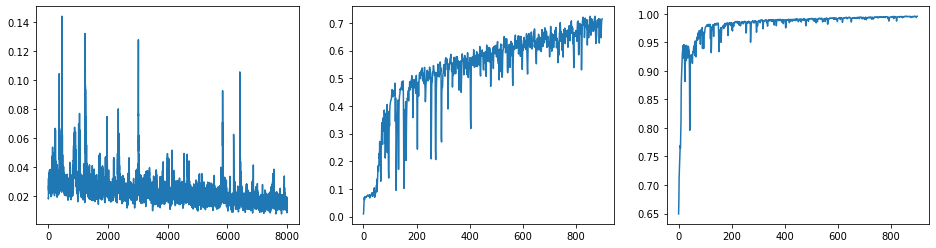

In [12]:
model.train()
# loss_v = []
# acc_v_node = []
# acc_v_edge = []
# ep = 0
for epoch in range(300):
    ep += 1
    node_correct = 0
    edge_correct = 0
    node_total = 0
    edge_total = 0 
    for batch in train_loader:
#         print(batch.x)
        optimizer.zero_grad()
        data = batch.to(device)
        edge_pred, node_pred = model(data)
        losses = [F.binary_cross_entropy_with_logits(edge_pred.float(), data.y.float()), F.mse_loss(node_pred, data.y_nodes.float())]
#         print(node_pred, data.y_nodes)
#         print(losses[0].item(), losses[1].item())
#         loss = F.mse_loss(node_pred, data.y_nodes.float())
        loss = sum(losses)
        loss_v.append(loss)
        loss.backward()
        optimizer.step()
        edge_pred = torch.sigmoid(edge_pred)
        edge_correct += ((edge_pred > 0.5) == (data.y > 0.5)).sum().item()
        # A "correct" track parameter is one where the pred. is within 5% of the truth
#         print(node_pred, data.y_nodes)
#         print((((node_pred - data.y_nodes)/data.y_nodes)**2 < 0.05**2).sum().item())
        node_correct += (((node_pred - data.y_nodes)/data.y_nodes)**2 < 0.1**2).sum().item()
        node_total += len(node_pred)*3
        edge_total += len(edge_pred)
#         print(out, data.y, )
    node_acc = node_correct/node_total
    edge_acc = edge_correct / edge_total
    scheduler.step()
    print("Epoch: " , ep, ", loss: ", loss.item(), ", node accuracy: ", node_acc, ", edge accuracy: ", edge_acc, " lr: ", scheduler.get_lr())
    acc_v_node.append(node_acc)
    acc_v_edge.append(edge_acc)

#     if node_acc > 0.5:
#         break
fig, axs = plt.subplots(1,3)
fig.set_size_inches(16,4)
axs[0].plot(np.arange(len(loss_v)-10000), loss_v[10000:])
axs[1].plot(np.arange(len(acc_v_node)), acc_v_node)
axs[2].plot(np.arange(len(acc_v_edge)), acc_v_edge)

In [11]:
model.eval()
for batch in test_loader:
    print(batch)
    data = batch.to(device)
    edge_pred, node_pred = model(data)
    edge_pred = torch.sigmoid(edge_pred)
    print(edge_pred, data.y, node_pred, data.y_nodes)
    correct = (((node_pred - data.y_nodes)/data.y_nodes)**2 < 0.1**2).sum().item()
    acc = correct / (len(node_pred)*3)
    print('Accuracy: {:.4f}'.format(acc))

Batch(batch=[590], edge_index=[2, 1306], x=[590, 2], y=[1306], y_nodes=[590, 3])
tensor([9.9988e-01, 5.7176e-05, 5.5821e-05,  ..., 9.9684e-01, 9.9235e-01,
        9.9960e-01], device='cuda:0', grad_fn=<SigmoidBackward>) tensor([1, 0, 0,  ..., 1, 1, 1], device='cuda:0') tensor([[ 0.7690, -0.1516, -0.9964],
        [ 0.8664, -0.6446,  0.9140],
        [ 0.3549, -0.0012, -1.0250],
        ...,
        [ 0.8418, -0.2584, -1.0032],
        [ 0.7953, -0.7268,  0.9783],
        [ 0.9042, -0.0975,  0.9827]], device='cuda:0', grad_fn=<SubBackward0>) tensor([[ 0.7565, -0.2249, -1.0000],
        [ 0.9527, -0.6698,  1.0000],
        [ 0.3600,  0.0168, -1.0000],
        ...,
        [ 0.9434, -0.2856, -1.0000],
        [ 0.9157, -0.7080,  1.0000],
        [ 0.7999, -0.1509,  1.0000]], device='cuda:0')
Accuracy: 0.5983


In [123]:
for pred, dat in zip(edge_pred, data.y):
    print(pred.item() < 0.5, dat.item() < 0.5)

True True
True True
False False
True True
False False
True True
True True
False False
True True
True True
True True
True True
False False
False False
True True
True True
False False
True False
True True
False False
True True
True True
True False
False False
True True
True True
True False
False False
True True
False False
True True
True True
False False
True False
True True
True False
False False
True True
True True
False False
False False
True True
True False
False False
True False
True True
False False
True False
False False
True True
True False
False False
True False
True False
True False
True True
True True
True True
True True
False False
True True
True True
True True
False False
True True
True True
True True
True True
True True
True True
False False
True True
False False
True True
True True
True True
True True
False False
True True
True True
True True
True True
True True
True True
True True
True True
True True
False False
True True
True True
False False
True True
True True
True Tru

In [125]:
for pred, dat in zip(node_pred, data.y_nodes):
    print(pred, dat)

tensor([1.8922e+01, 3.6313e+00, 3.0467e-03], device='cuda:0',
       grad_fn=<SelectBackward>) tensor([16.0778,  3.4214,  1.0000], device='cuda:0')
tensor([ 46.2187, -35.0857,   0.6955], device='cuda:0',
       grad_fn=<SelectBackward>) tensor([ 43.2096, -32.9716,   1.0000], device='cuda:0')
tensor([ 1.8613e+01,  3.5876e+00, -1.0034e-04], device='cuda:0',
       grad_fn=<SelectBackward>) tensor([16.0778,  3.4214,  1.0000], device='cuda:0')
tensor([ 1.8996e+01,  2.9768e+00, -4.8119e-03], device='cuda:0',
       grad_fn=<SelectBackward>) tensor([16.0778,  3.4214,  1.0000], device='cuda:0')
tensor([25.8152, 16.9260, -1.2471], device='cuda:0', grad_fn=<SelectBackward>) tensor([27.9215, 18.2583, -1.0000], device='cuda:0')
tensor([25.4800, 16.8262, -1.2453], device='cuda:0', grad_fn=<SelectBackward>) tensor([27.9215, 18.2583, -1.0000], device='cuda:0')
tensor([24.8583, 16.6111, -1.2062], device='cuda:0', grad_fn=<SelectBackward>) tensor([27.9215, 18.2583, -1.0000], device='cuda:0')
tensor([2

tensor([31.0132, 26.7924, -1.1592], device='cuda:0', grad_fn=<SelectBackward>) tensor([32.1656, 27.2873, -1.0000], device='cuda:0')
tensor([24.7528, 11.4088,  1.0851], device='cuda:0', grad_fn=<SelectBackward>) tensor([22.9298, 10.3572,  1.0000], device='cuda:0')
tensor([46.1363, -8.4528,  1.1295], device='cuda:0', grad_fn=<SelectBackward>) tensor([48.2970, -9.6577,  1.0000], device='cuda:0')
tensor([ 41.6044, -27.0621,  -1.0020], device='cuda:0',
       grad_fn=<SelectBackward>) tensor([ 42.0909, -26.7089,  -1.0000], device='cuda:0')
tensor([ 40.1575, -25.1728,  -1.2345], device='cuda:0',
       grad_fn=<SelectBackward>) tensor([ 42.0909, -26.7089,  -1.0000], device='cuda:0')
tensor([ 4.7806e+01,  5.0180e+00, -1.6837e-03], device='cuda:0',
       grad_fn=<SelectBackward>) tensor([45.4910,  4.0459,  1.0000], device='cuda:0')
tensor([4.1045e+01, 6.2937e+00, 1.2046e-02], device='cuda:0',
       grad_fn=<SelectBackward>) tensor([15.3100,  4.1804,  1.0000], device='cuda:0')
tensor([29.7276

       grad_fn=<SelectBackward>) tensor([ 45.1559, -27.4095,  -1.0000], device='cuda:0')
tensor([ 32.2616, -19.1610,   0.9457], device='cuda:0',
       grad_fn=<SelectBackward>) tensor([ 42.3723, -23.8952,   1.0000], device='cuda:0')
tensor([ 50.7671, -27.0119,  -1.0360], device='cuda:0',
       grad_fn=<SelectBackward>) tensor([ 45.1559, -27.4095,  -1.0000], device='cuda:0')
tensor([ 31.1080, -17.7125,   0.6052], device='cuda:0',
       grad_fn=<SelectBackward>) tensor([ 32.0675, -16.8338,   1.0000], device='cuda:0')
tensor([ 39.6060, -23.2370,  -1.2991], device='cuda:0',
       grad_fn=<SelectBackward>) tensor([ 49.4276, -31.1958,  -1.0000], device='cuda:0')
tensor([26.9951,  8.1046, -0.8100], device='cuda:0', grad_fn=<SelectBackward>) tensor([26.9997,  8.4866, -1.0000], device='cuda:0')
tensor([ 29.6949, -16.4559,   1.0694], device='cuda:0',
       grad_fn=<SelectBackward>) tensor([ 32.0675, -16.8338,   1.0000], device='cuda:0')
tensor([ 36.1768, -20.4686,   0.6178], device='cuda:0'

       grad_fn=<SelectBackward>) tensor([45.9062, -8.7200, -1.0000], device='cuda:0')
tensor([22.0105, 14.7682,  0.4353], device='cuda:0', grad_fn=<SelectBackward>) tensor([22.2387, 15.0933,  1.0000], device='cuda:0')
tensor([ 42.1805, -14.1110,  -1.3199], device='cuda:0',
       grad_fn=<SelectBackward>) tensor([ 44.6086, -15.7559,  -1.0000], device='cuda:0')
tensor([ 33.1469, -12.6442,  -0.5486], device='cuda:0',
       grad_fn=<SelectBackward>) tensor([ 44.6086, -15.7559,  -1.0000], device='cuda:0')
tensor([22.9424, 13.8233,  0.7787], device='cuda:0', grad_fn=<SelectBackward>) tensor([22.2387, 15.0933,  1.0000], device='cuda:0')
tensor([ 39.9691, -30.4766,   1.3957], device='cuda:0',
       grad_fn=<SelectBackward>) tensor([ 46.1681, -33.3355,   1.0000], device='cuda:0')
tensor([ 46.1071, -32.6982,   0.8277], device='cuda:0',
       grad_fn=<SelectBackward>) tensor([ 46.1681, -33.3355,   1.0000], device='cuda:0')
tensor([ 36.9858, -22.7988,   0.9687], device='cuda:0',
       grad_fn

In [65]:
dir(tnn)

['AGNNConv',
 'APPNP',
 'ARGA',
 'ARGVA',
 'ARMAConv',
 'ChebConv',
 'DNAConv',
 'DataParallel',
 'DeepGraphInfomax',
 'DenseGCNConv',
 'DenseGINConv',
 'DenseSAGEConv',
 'DynamicEdgeConv',
 'ECConv',
 'EdgeConv',
 'FeaStConv',
 'GAE',
 'GATConv',
 'GCNConv',
 'GINConv',
 'GMMConv',
 'GatedGraphConv',
 'GlobalAttention',
 'GraphConv',
 'HypergraphConv',
 'InnerProductDecoder',
 'JumpingKnowledge',
 'MessagePassing',
 'MetaLayer',
 'NNConv',
 'PPFConv',
 'PointConv',
 'RENet',
 'RGCNConv',
 'Reshape',
 'SAGEConv',
 'SAGPooling',
 'SGConv',
 'Set2Set',
 'SignedConv',
 'SignedGCN',
 'SplineConv',
 'TopKPooling',
 'VGAE',
 'XConv',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'avg_pool',
 'avg_pool_x',
 'conv',
 'data_parallel',
 'dense',
 'dense_diff_pool',
 'fps',
 'glob',
 'global_add_pool',
 'global_max_pool',
 'global_mean_pool',
 'global_sort_pool',
 'graclus',
 'inits',
 'knn',
 'knn_graph